For this project, I am investigating purchasing a house near Melbourne, Victoria, Australia. I have sourced two datasets, the first being sold house price data for greater Melbourne, and the second being crime statistics. I will use these to find the optimal location to purchase a property, considering:
- Crime rates across suburbs
- Distance to Melbourne CBD
- Property prices

I aim to identify a cheap suburb with low crime that is commuting distance to the CBD. 

In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
import os
%matplotlib inline

In [7]:
password = os.environ.get('sql_password')

In [5]:
pathway = "postgresql+psycopg2://postgres:" + password + "@localhost:5432/RealEstateProject"
engine = create_engine(pathway)
melb_sold_property = pd.read_sql_table('melb_houses',engine)

In [6]:
melb_sold_property['date'] = pd.to_datetime(melb_sold_property['date'], format='%d/%m/%Y')
melb_sold_property.info()
dwelling_label_dict = {'h':'House', 'u': 'Apartment', 't':'Townhouse'}
melb_sold_property['type'] = melb_sold_property['type'].replace(dwelling_label_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
suburb           34857 non-null object
address          34857 non-null object
rooms            34857 non-null int64
type             34857 non-null object
price            27247 non-null float64
method           34857 non-null object
sellerg          34857 non-null object
date             34857 non-null datetime64[ns]
distance         34856 non-null float64
postcode         34856 non-null object
bedroom2         26640 non-null float64
bathroom         26631 non-null float64
car              26129 non-null float64
landsize         23047 non-null float64
buildingarea     13742 non-null float64
yearbuilt        15551 non-null float64
councilarea      34854 non-null object
lattitude        26881 non-null float64
longtitude       26881 non-null float64
regionname       34854 non-null object
propertycount    34854 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), obje

(array([735964., 736055., 736146., 736238., 736330., 736420., 736511.,
        736603., 736695., 736785.]), <a list of 10 Text xticklabel objects>)

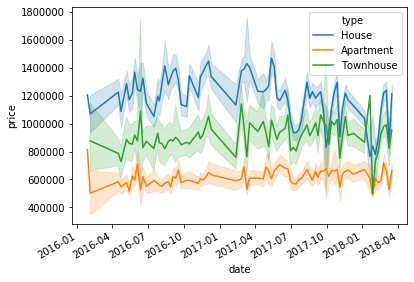

In [12]:
sns.lineplot(x='date', y='price', data=melb_sold_property, hue='type')
plt.xticks(rotation=30, ha='right')

In [55]:
price_by_suburb_mean = melb_sold_property.groupby(melb_sold_property['suburb']).mean().sort_values('price', ascending=True).filter(['suburb','price'], axis=1)
price_by_suburb_mean.head()

,price
suburb,
Darley,380000.000000
Kurunjang,380653.846154
Bacchus Marsh,423000.000000
Melton South,423691.964286
Melton,434583.333333


In [40]:
crime = pd.read_csv('~/Projects/Apartment buying project/offences_vic.csv')
crime.head()

,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population"
0,2019,December,1 North West Metro,Banyule,9524,7247.3
1,2019,December,1 North West Metro,Brimbank,19784,9410.5
2,2019,December,1 North West Metro,Darebin,14532,8854.9
3,2019,December,1 North West Metro,Hobsons Bay,6224,6376.7
4,2019,December,1 North West Metro,Hume,21445,9204.3


In [57]:
crime_by_lga_mean = crime.groupby(crime['Local Government Area']).mean().sort_values('Rate per 100,000 population').drop(labels = ['Year','Offence Count'], axis=1).reset_index()

crime_by_lga_mean = crime_by_lga_mean[crime_by_lga_mean['Rate per 100,000 population'].notna()]
print(crime_by_lga_mean)

Local Government Area  Rate per 100,000 population
0          Golden Plains                      2798.37
1                 Indigo                      3007.20
2              Nillumbik                      3530.48
3             Manningham                      3566.31
4                  Moyne                      3633.87
..                   ...                          ...
75               Mildura                     11511.42
76               Horsham                     12059.93
77                 Yarra                     13955.56
78               Latrobe                     15874.90
79             Melbourne                     26239.71

[80 rows x 2 columns]


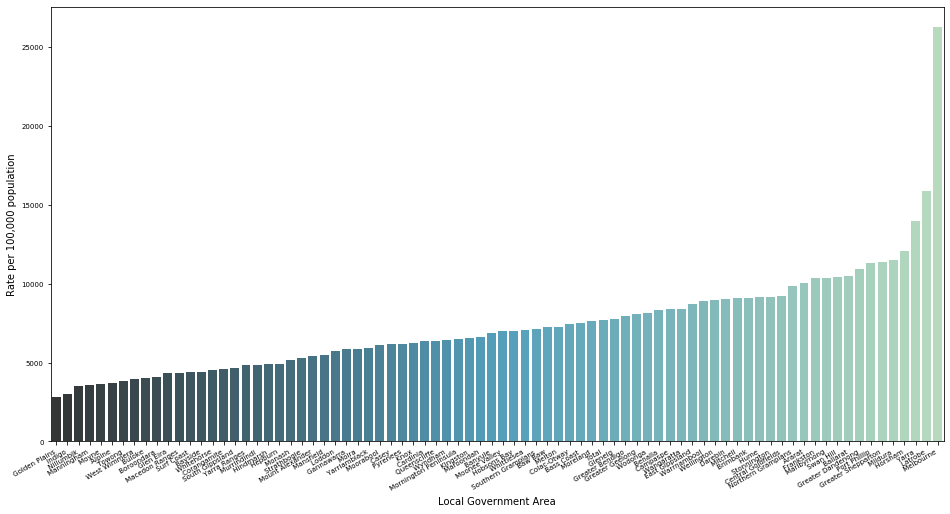

In [58]:
plt.figure(figsize=(16,8))
crime_plot = sns.barplot(x='Local Government Area', y='Rate per 100,000 population', data=crime_by_lga_mean, order=crime_by_lga_mean['Local Government Area'], palette="GnBu_d")
plt.xticks(rotation=30, ha='right')
crime_plot.tick_params(labelsize=7)

Now that I have visualised which Local Government Areas (LGAs) have the lowest crime rates, I will extract the LGAs with a crime rate < 5000 per 100,000 residents that are a commutable distance to the CBD (less than 50km). Next, I will analyse the property prices and distance to Melbourne CBD in these areas, to optimise the location in which I will buy.

In [59]:
lowest_crime_areas = crime_by_lga_mean[crime_by_lga_mean['Rate per 100,000 population'] <= 5000]
print(lowest_crime_areas['Local Government Area'])

0        Golden Plains
1               Indigo
2            Nillumbik
3           Manningham
4                Moyne
5               Alpine
6               Towong
7         West Wimmera
8               Buloke
9           Boroondara
10           Glen Eira
11      Macedon Ranges
12          Surf Coast
13             Bayside
14          Whitehorse
15         Corangamite
16     South Gippsland
17        Yarra Ranges
18         Murrindindi
19           Hindmarsh
20             Hepburn
Name: Local Government Area, dtype: object


In [43]:
lowest_crime_dist_to_cbd = {'Golden Plains': 112, 'Indigo': 303, 'Nillumbik': 46, 'Manningham': 24, 'Moyne': 259, 'Alpine': 328, 'Towong': 455, 'West Wimmera': 403, 'Buloke': 271, 'Boroondara': 16, 'Glen Eira': 14, 'Macedon Ranges': 89, 'Surf Coast': 120, 'Bayside': 19, 'Whitehorse': 24, 'Corangamite': 190, 'South Gippsland': 162, 'Yarra Ranges': 80, 'Murrindindi': 101, 'Hindmarsh': 405, 'Hepburn': 119}

low_crime_commutable_to_cbd = dict()
for (key, value) in lowest_crime_dist_to_cbd.items():
   if value < 50:
       low_crime_commutable_to_cbd[key] = value
print(low_crime_commutable_to_cbd)

{'Nillumbik': 46, 'Manningham': 24, 'Boroondara': 16, 'Glen Eira': 14, 'Bayside': 19, 'Whitehorse': 24}


In [37]:
lgas = [
    {
        'name': 'Nillumbik',
        'suburbs':[
            'Arthurs Creek',
            'Bend of Islands',
            'Christmas Hills',
            'Cottles Bridge',
            'Greensborough',
            'Diamond Creek',
            'Doreen',
            'Eltham',
            'Eltham North',
            'Hurstbridge',
            'Kangaroo Ground',
            'Kinglake',
            'Kinglake West',
            'North Warrandyte',
            'Nutfield',
            'Panton Hill',
            'Plenty',
            'Research',
            'Smiths Gully',
            'St Andrews',
            'Strathewen',
            'Watsons Creek',
            'Wattle Glen'
            'Yan Yean',
            'Yarrambat']
    },
    {
        'name':'Manningham',
        'suburbs':[
            'Bulleen',
            'Doncaster',
            'Doncaster East',
            'Donvale',
            'Park Orchards',
            'Templestowe',
            'Templestowe Lower',
            'Warrandyte',
            'Warrandyte South',
            'Wonga Park']
    },
    {
        'name':'Boroondara',
        'suburbs':[
            'Balwyn North', 
            'Kew East', 
            'Kew', 
            'Balwyn',
            'Deepdene', 
            'Glen Iris', 
            'Hawthorn East', 
            'Hawthorn', 
            'Camberwell', 
            'Canterbury', 
            'Surrey Hills', 
            'Mont Albert North', 
            'Ashburton']
    },
    {
        'name': 'Glen Eira',
        'suburbs':[
            'Bentleigh',
            'Bentleigh East',
            'Brighton East',
            'Carnegie',
            'Caulfield',
            'Caulfield East',
            'Caulfield North',
            'Caulfield South',
            'Elsternwick',
            'Gardenvale',
            'Glen Huntly',
            'McKinnon',
            'Murrumbeena',
            'Ormond',
            'St Kilda East']
    },
    {
        'name': 'Bayside', 
        'suburbs':[
            'Beaumaris',
            'Black Rock',
            'Brighton',
            'Brighton East',
            'Cheltenham',
            'Hampton',
            'Hampton East',
            'Highett',
            'Sandringham']
    },
    {
        'name': 'Whitehorse',
        'suburbs':[
            'Blackburn',
            'Blackburn North',
            'Blackburn South',
            'Box Hill',
            'Box Hill North',
            'Box Hill South',
            'Burwood',
            'Burwood East',
            'Forest Hill',
            'Mitcham',
            'Mont Albert',
            'Mont Albert North',
            'Nunawading',
            'Surrey Hills',
            'Vermont',
            'Vermont South']
    }
]

In [45]:
extracted_lists_low_crime_suburbs = [dictionary['suburbs'] for dictionary in lgas]
low_crime_suburbs = [suburb for ls in extracted_lists_low_crime_suburbs for suburb in ls]
properties_in_low_crime_suburbs = melb_sold_property[melb_sold_property.suburb.isin(low_crime_suburbs)]
properties_in_low_crime_suburbs = properties_in_low_crime_suburbs[properties_in_low_crime_suburbs.price.notnull()]

(array([735964., 736055., 736146., 736238., 736330., 736420., 736511.,
        736603., 736695., 736785.]), <a list of 10 Text xticklabel objects>)

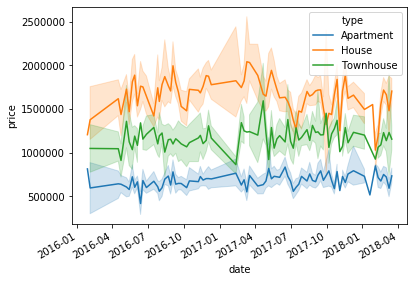

In [47]:
sns.lineplot(x='date', y='price', data=properties_in_low_crime_suburbs, hue='type')
plt.xticks(rotation=30, ha='right')

In [48]:
concatenated_property_data = pd.concat([melb_sold_property.assign(dataset='All properties'),properties_in_low_crime_suburbs.assign(dataset='Low crime areas')], axis=0).reset_index(drop=True)
concatenated_property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42063 entries, 0 to 42062
Data columns (total 22 columns):
suburb           42063 non-null object
address          42063 non-null object
rooms            42063 non-null int64
type             42063 non-null object
price            34453 non-null float64
method           42063 non-null object
sellerg          42063 non-null object
date             42063 non-null datetime64[ns]
distance         42062 non-null float64
postcode         42062 non-null object
bedroom2         32016 non-null float64
bathroom         32005 non-null float64
car              31474 non-null float64
landsize         27762 non-null float64
buildingarea     16348 non-null float64
yearbuilt        18596 non-null float64
councilarea      42059 non-null object
lattitude        32302 non-null float64
longtitude       32302 non-null float64
regionname       42059 non-null object
propertycount    42059 non-null float64
dataset          42063 non-null object
dtypes: datetim

(array([735964., 736055., 736146., 736238., 736330., 736420., 736511.,
        736603., 736695., 736785.]), <a list of 10 Text xticklabel objects>)

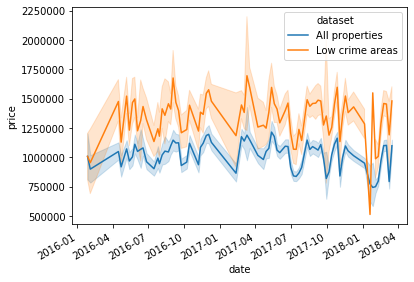

In [49]:
sns.lineplot(x='date', y='price', data=concatenated_property_data, hue='dataset')
plt.xticks(rotation=30, ha='right')

Buying a property in a low crime area, within 50km of the Melbourne CBD is likely to be more expensive than buying further away and/or in higher crime areas. 
Now to find the cheapest low-crime suburb.

In [51]:
cheapest_suburbs_low_crime = properties_in_low_crime_suburbs.groupby(['suburb', 'councilarea']).median().filter(['suburb','price','councilarea'], axis=1).sort_values('price', ascending=True).reset_index()
cheapest_suburbs_low_crime.head(15)

,suburb,councilarea,price
0,Doreen,Nillumbik Shire Council,550000.0
1,Glen Huntly,Glen Eira City Council,600000.0
2,Caulfield North,Glen Eira City Council,609000.0
3,Gardenvale,Glen Eira City Council,643500.0
4,Caulfield,Glen Eira City Council,644000.0
5,Hurstbridge,Nillumbik Shire Council,695000.0
6,Diamond Creek,Nillumbik Shire Council,742500.0
7,Hawthorn,Boroondara City Council,750500.0
8,Research,Nillumbik Shire Council,810000.0
9,Greensborough,Banyule City Council,816000.0


The cheapest suburb is Doreen, in the Nillumbik Shire, however, it is ~46km from the CBD. Finding a house in Glen Huntly looks to be my best option: it is the second cheapest suburb with crime rates lower than 5000 incidents per 100,000 people, and only 11km from the CBD. Glen Huntly has a median price of $600,000.

In [52]:
print(properties_in_low_crime_suburbs[properties_in_low_crime_suburbs['suburb'] == 'Glen Huntly'].groupby(['type']).median().filter(['type', 'price']).reset_index())

type      price
0  Apartment   517500.0
1      House  1330000.0
2  Townhouse   725000.0
